# Point Cloud Classification with PointNet

In [2]:
!pip install trimesh
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.8/693.8 kB 7.2 MB/s eta 0:00:00


In [3]:
# Use hardware accelerator for training
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#print("GPUs Available: ", len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Download the Dataset

In [4]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473402300/473402300 [==============================] - 8s 0us/step


## Visualize a Mesh from the Dataset

In [5]:
mesh = trimesh.load(os.path.join(DATA_DIR, "bed/train/bed_0001.off"))
mesh.show()

## Sample a Mesh and Show Result

In [6]:
!pip install rtree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.2/535.2 kB 7.6 MB/s eta 0:00:00


[1142 1142 1159 ... 1137 1414 1132]


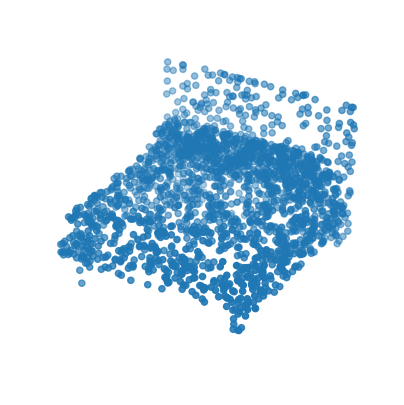

In [7]:
points_test=trimesh.sample.sample_surface(mesh, count=2048)
faces=points_test[1]
print(faces)
points_test=points_test[0]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_test[:, 0], points_test[:, 1], points_test[:, 2])
ax.set_axis_off()
plt.show()


In [8]:
print (points_test[1])

[21.88652878 26.65550684  0.75      ]


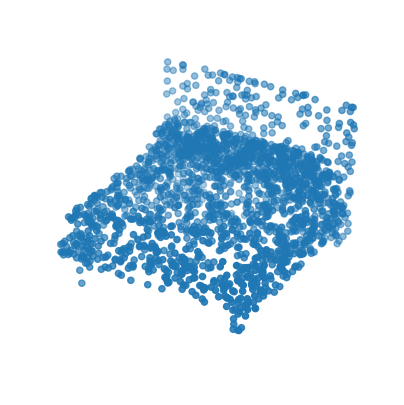

In [9]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_test[:, 0], points_test[:, 1], points_test[:, 2])
ax.set_axis_off()
plt.show()

In [10]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [11]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class: toilet
processing class: sofa
processing class: dresser
processing class: chair
processing class: table
processing class: bed
processing class: desk
processing class: night_stand
processing class: bathtub
processing class: monitor


In [12]:
def gaussian_noise(data, mean=0, std=20):#j'ai exprès augmenter la variance afin de voir que ci vraiment le bruit existe et de s'assusurer qu'il ne touchee pas la data d'origine dans la data augmentée
    noise = np.random.normal(mean, std, size=data.shape)
    return data + noise

In [13]:
#noisy_train = gaussian_noise(train_points)
#noisy_test = gaussian_noise(test_points)

In [14]:
def augment_class_data(class_data, num_duplicates=1):
    augmented_data = []
    for _ in range(num_duplicates):
        noisy_data = gaussian_noise(class_data)
        augmented_data.append(noisy_data)
        augmented_data.append(class_data)
    return np.vstack(augmented_data)  # ici j'ai rencontré probleme de shape qui n'était pas adéquate au shape initiale de data d'input , c'est pour cela j'ai utilisé vstack


In [15]:
def augment_dataset(data, labels, num_duplicates=1):#on peut remplacer num dupli par d'autre , si on veut par exemple ajouter d'autre bruit sauf ceci et etc
    augmented_data = []
    augmented_labels = []
    unique_labels = np.unique(labels)
    for label in unique_labels:
        class_indices = np.where(labels == label)[0]
        class_data = data[class_indices]
        augmented_class_data = augment_class_data(class_data, num_duplicates)
        augmented_data.extend(augmented_class_data)
        augmented_labels.extend([label] * len(augmented_class_data))
    return ( np.array(augmented_data), np.array(augmented_labels))
# en haut on parcourt chaque classe de chaque categ soit de train ou de test on s'en fou , mais pour chaque classe on augmente son data en la dupliquant et c'est à l'elem dupliquee qu'on ajoute le bruit
# on applique cette perception sur notre data
train_points_augmented, train_labels_augmented = augment_dataset(train_points, train_labels, num_duplicates=1)

test_points_augmented, test_labels_augmented = augment_dataset(test_points, test_labels, num_duplicates=1)


In [16]:
print (train_points.shape)

(3991, 2048, 3)


In [17]:
print (train_points_augmented.shape) # wala c'est bien ce qu'on veut

(7982, 2048, 3)


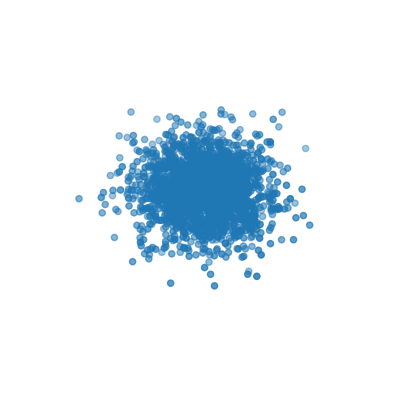

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
element = train_points_augmented[2058]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(element[:, 0], element[:, 1], element[:, 2])
ax.set_axis_off()
plt.show()


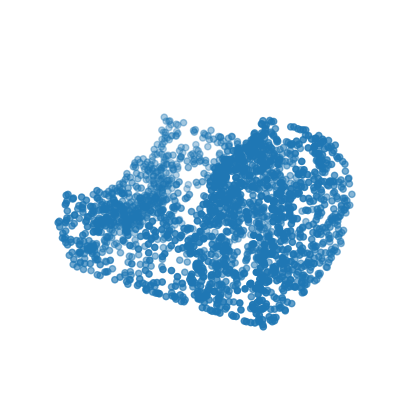

In [19]:
from mpl_toolkits.mplot3d import Axes3D
element = train_points[565]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(element[:, 0], element[:, 1], element[:, 2])
ax.set_axis_off()
plt.show()


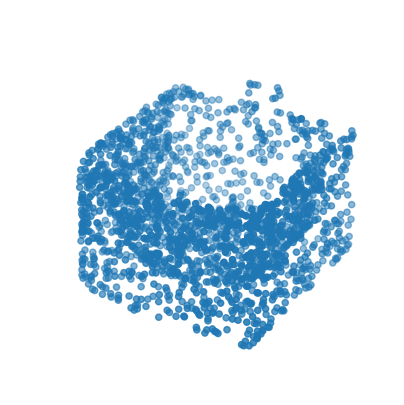

In [20]:
# Afficher l'élément correspondant
element = train_points_augmented[7000]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(element[:, 0], element[:, 1], element[:, 2])
ax.set_axis_off()
plt.show()

#**Pour** ajouter des points aberrants
c'est le meme principe , sauf que on peut tout faire dans une boucle , et avec la boucle while , mais pour le moment je ne veux pas toucher ce que j'ai fait evitant d'avoir un erreur qui va me fe=aire perdre tout le travail

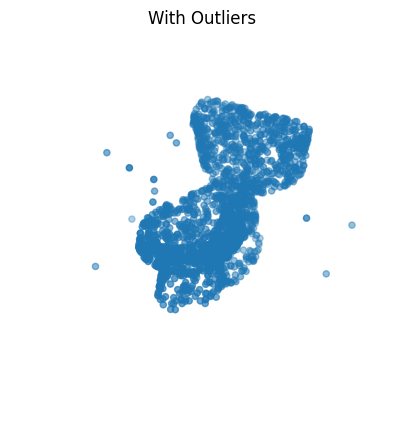

In [21]:
import numpy as np
import tensorflow as tf

def add_outliers(points, outlier_ratio=0.01):
    num_outliers = int(points.shape[1] * outlier_ratio)
    num_points = points.shape[1]
    mean_points = tf.reduce_mean(points, axis=1, keepdims=True)
    max_value = tf.reduce_max(points)
    min_value = tf.reduce_min(points)
    extreme_value = tf.maximum(tf.abs(max_value), tf.abs(min_value)) * 1.2  # Choisissez une valeur extrême arbitrairement grande
    outlier_points = tf.random.uniform((num_outliers, 3), minval=-extreme_value, maxval=extreme_value, dtype=tf.float64)
    updated_points = tf.concat([points, tf.expand_dims(outlier_points, axis=0)], axis=1)
    return updated_points

element = train_points[1]

element_with_outliers = add_outliers(tf.expand_dims(element, axis=0))

# Visualisation de l'élément avec des points aberrants
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(element_with_outliers[0, :, 0], element_with_outliers[0, :, 1], element_with_outliers[0, :, 2])
ax.set_title('With Outliers')
ax.set_axis_off()

plt.show()


# Rotation

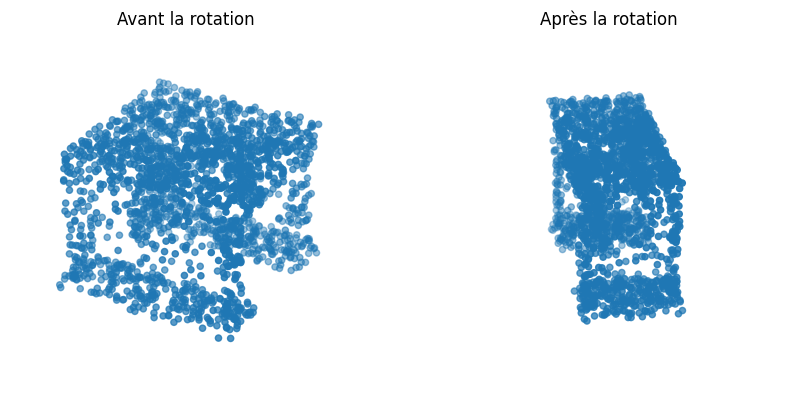

In [22]:
import numpy as np

def rotate_point_cloud_z(point_cloud, angle_degrees):
    angle_radians = np.radians(angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle_radians), -np.sin(angle_radians), 0],
        [np.sin(angle_radians), np.cos(angle_radians), 0],
        [0, 0, 1]
    ])
    rotated_point_cloud = np.dot(point_cloud, rotation_matrix.T)
    return rotated_point_cloud


# Sélection aléatoire d'un nuage de points
random_index = np.random.randint(0, len(train_points))
point_cloud = train_points[random_index]

# Angle de rotation souhaité (par exemple 40 degrés)
angle_rotation = 40

# Rotation du nuage de points selon l'angle spécifié autour de l'axe Z
rotated_point_cloud = rotate_point_cloud_z(point_cloud, angle_rotation)

# Visualisation avant la rotation
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection="3d")
ax1.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2])
ax1.set_title("Avant la rotation")
ax1.set_axis_off()

# Visualisation après la rotation
ax2 = fig.add_subplot(122, projection="3d")
ax2.scatter(rotated_point_cloud[:, 0], rotated_point_cloud[:, 1], rotated_point_cloud[:, 2])
ax2.set_title("Après la rotation")
ax2.set_axis_off()

plt.show()

In [23]:
import numpy as np

def rotate_point_cloud_z(point_cloud, angle_degrees):
    angle_radians = np.radians(angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle_radians), -np.sin(angle_radians), 0],
        [np.sin(angle_radians), np.cos(angle_radians), 0],
        [0, 0, 1]
    ])
    rotated_point_cloud = np.dot(point_cloud, rotation_matrix.T)
    return rotated_point_cloud

def gaussian_noise(data, mean=0, std=20):
    noise = np.random.normal(mean, std, size=data.shape)
    return data + noise

def augment_class_data_with_rotation(class_data, num_duplicates=1):
    augmented_data = []
    angles = [40, 80, 120, 170]  # Liste des angles de rotation
    for angle in angles:
        for _ in range(num_duplicates):
            # Rotation de chaque élément de classe
            rotated_data = rotate_point_cloud_z(class_data, angle)
            augmented_data.append(rotated_data)
    return np.vstack(augmented_data)

def augment_dataset_with_rotation_and_noise(data, labels, num_duplicates=1):
    augmented_data = []
    augmented_labels = []
    unique_labels = np.unique(labels)
    for label in unique_labels:
        class_indices = np.where(labels == label)[0]
        class_data = data[class_indices]
        for _ in range(num_duplicates):
            # Ajout de rotation à chaque élément de classe avec bruit
            augmented_class_data = augment_class_data_with_rotation(class_data)
            max_shape = max([data.shape for data in augmented_class_data])
            augmented_class_data_resized = [np.pad(data, ((0, max_shape[0] - data.shape[0]), (0, 0)), mode='constant') for data in augmented_class_data]
            augmented_data.extend(augmented_class_data_resized)
            augmented_labels.extend([label] * len(augmented_class_data_resized))
    return np.array(augmented_data), np.array(augmented_labels)


# Utilisation de la fonction pour augmenter les données avec bruit et rotation
train_points_augmented_with_rotation_and_noise, train_labels_augmented_with_rotation_and_noise = augment_dataset_with_rotation_and_noise(train_points_augmented, train_labels_augmented, num_duplicates=1)
test_points_augmented_with_rotation_and_noise, test_labels_augmented_with_rotation_and_noise = augment_dataset_with_rotation_and_noise(test_points_augmented, test_labels_augmented, num_duplicates=1)


In [24]:
print (len(train_points_augmented_with_rotation_and_noise))

31928


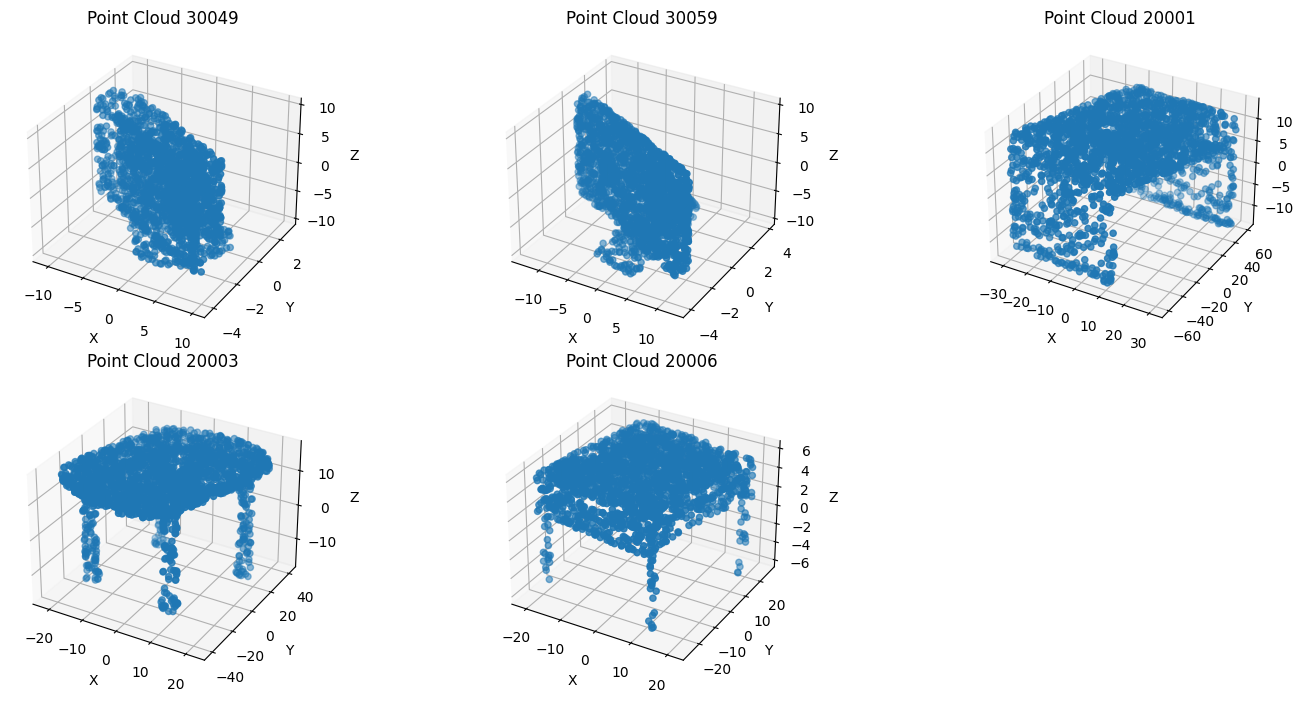

In [65]:
import matplotlib.pyplot as plt

# Définir une fonction pour afficher les nuages de points
def plot_point_clouds(point_clouds, indices):
    fig = plt.figure(figsize=(15, 7))
    num_plots = len(indices)
    for i, idx in enumerate(indices):
        ax = fig.add_subplot(2, num_plots//2 + 1, i+1, projection='3d')
        ax.scatter(point_clouds[idx][:, 0], point_clouds[idx][:, 1], point_clouds[idx][:, 2])
        ax.set_title(f"Point Cloud {idx}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
    plt.tight_layout()
    plt.show()

# Indices des éléments à afficher
indices_to_show = [30049, 30059, 20001, 20003, 20006]  # Par exemple, choisissez les indices que vous souhaitez visualiser

# Afficher les éléments correspondant aux indices spécifiés
plot_point_clouds(train_points_augmented_with_rotation_and_noise, indices_to_show)
